# État de l'emploi bioinformatique en France : partie 2

Nous revoila pour la suite de notre [premier article](http://bioinfo-fr.net/etat-de-lemploi-bioinformatique-en-france-analyse-des-offres-de-la-sfbi) sur l'analyse des offres de la SFBI des 4 dernières années.
On vous avait promis une analyse de l'évolution du marché, et c'est ce dont nous allons parler dans cet article.

Je vous renvoie au premier article si vous voulez plus d'informations sur l'origine des données et la disponibilité du code.
Les contributions sur le [Github du projet](https://github.com/royludo/SFBIStats) ont été bien ternes... ou plutôt inexistantes.
C'est bien dommage car nous nourrissions le secret espoir de publier ici vos meilleurs graphes.
Du coup, on a dû tout faire nous même, entre de la rédaction de chapîtres de thèses ou l'analyse de données microfluidiques.

Le code n'est probablement pas facile à prendre en main.
Nous avons ainsi choisi un format _jupyter notebook_ pour ce second article.
Texte, code et graphes sont mélés dans ce qui suit, en espérant que ça suscite des vocations pour améliorer nos graphes, et surtout, en créer d'autres.
L'article est, de fait, un poil plus technique que le précédent.
Notons qu'il s'agit d'un excellent exemple de l'utilisation du module python [pandas](http://pandas.pydata.org/) sur des données réelles.

## Chargement des modules nécessaires et des données

On entre donc dans le vif du sujet en commençant par charger les données de la base de données MongoDB que [lroy](http://bioinfo-fr.net/crew) a gentillement mise à jour sur le github depuis le premier article.

In [1]:
from __future__ import unicode_literals, print_function
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100 # bigger figures in notebook mode
matplotlib.rcParams['savefig.dpi'] = 100 # bigger figures in inline mode
colors = ['#6f3883', '#87ad3e', '#fce33e', '#4066c7', '#cc3428'] # colorpalette from bioinfo-fr
import json, os
from bson import json_util
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import numpy as np
from sfbistats import utils

In [2]:
with open('../../resources/jobs_anon.json', 'r') as input_file: # emplacement de la BDD
    job_list = utils.load_from_json(input_file) # création de la liste de jobs
print('Nombre total d\'offres', len(job_list))
print('Champs :', job_list[0].keys())

Nombre total d'offres 2595
Champs : dict_keys(['submission_date', 'limit_date', 'city', 'starting_date', 'validity_date', 'contract_type', 'department', 'title', 'duration', 'region', 'contract_subtype'])


On constate que l'on a gagné environ 150 offres depuis mi-février. Vous pouvez voir que chaque offre dans job_list est un dictionnaire qui contient 11 clés. Comme ce n'est pas très pratique à manipuler, on va créer ce que l'on appelle un dataframe grâce au module Pandas. Au passage on ne va récupérer que les champs potentiellement intéressants pour cet article.

In [3]:
df = pd.DataFrame(job_list, columns=['contract_type',
                                     'contract_subtype',
                                     'duration',
                                     'submission_date'])
df.submission_date = pd.to_datetime(df.submission_date)
df.duration = df.duration.astype(int)
df.describe(include='all') # On affiche un résumé du dataframe.

,contract_type,contract_subtype,duration,submission_date
count,2595,2595,2595.000000,2595
unique,4,11,NaN,1070
top,CDD,,NaN,2015-11-09 00:00:00
freq,1311,848,NaN,12
first,NaN,NaN,NaN,2012-04-23 00:00:00
last,NaN,NaN,NaN,2018-01-12 00:00:00
mean,NaN,NaN,14.423892,NaN
std,NaN,NaN,56.977162,NaN
min,NaN,NaN,-1.000000,NaN
25%,NaN,NaN,4.000000,NaN


Ce petit tableau généré par la fonction describe de Pandas est très pratique. Il nous donne pour chaque champ le nombre total d'offres, le nombre de champs uniques (par exemple, 4 types de contrats), celui qui ressort le plus souvent (les CDD), et le nombre de fois qu'il ressort (785 fois). On peut également voir que la première offre date du 23 avril 2012, et que la dernière est du 19 mai 2016 (date à laquelle a été mise à jour la base de données).

## Evolution du nombre d'offres sur la période 2012-2016

Premier exemple avec un petit graphe tout simple : peut-on tracer l'évolution de la quantité d'offres au cours du temps ? On peut obtenir ça très facilement en quelques lignes avec la puissance du module Pandas.

In [4]:
# On prend la colonne submission_date du dataframe et on rééchantillonne
# par bimestre (pour plus de lisibilité)
date_serie = df.submission_date.value_counts().resample('2M', how='sum')
date_serie.head() # On affiche un aperçu du résultat (5 premières lignes)

/home/ludovic/miniconda2/envs/test_python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


2012-04-30     3
2012-06-30     9
2012-08-31    10
2012-10-31    20
2012-12-31    20
Freq: 2M, Name: submission_date, dtype: int64

Comme vous pouvez le voir, on obtient en une seule ligne de code l'information demandée, il ne reste plus qu'à optimiser l'affichage.

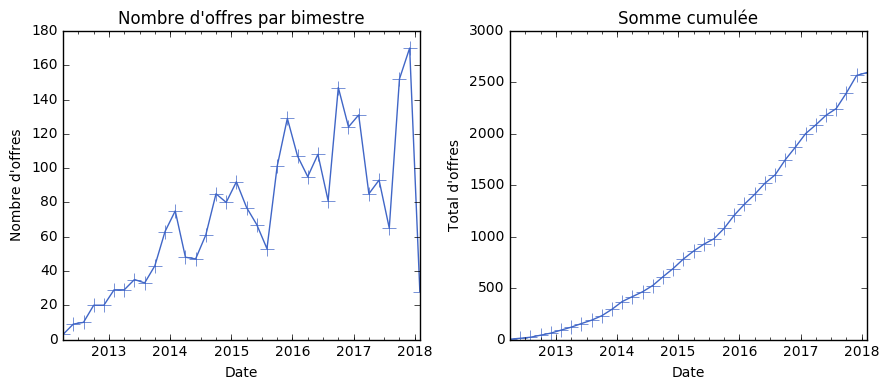

In [5]:
kwargsplot = {'marker': '+', 'markersize': 10, 'color': colors[3], 'lw': 1, 'ls': '-'}
fig, axx = plt.subplots(1,2, figsize=(9,4))
date_serie.plot(ax=axx[0], **kwargsplot) # on affiche la somme par bimestre
date_serie.cumsum().plot(ax=axx[1], **kwargsplot) # on affiche la somme cumulée

axx[0].set_title(u'Nombre d\'offres par bimestre')
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title(u'Somme cumulée')
axx[1].set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
fig.tight_layout()

Puissant n'est-ce pas ?

Nous avons décidé de regrouper les données par bimestre (tranches de 2 mois) car les données sont très bruitées d'un mois sur l'autre, ce qui rend la visualisation difficile. Les points correspondent à des fins de mois et comprennent toutes les offres des 2 mois précédents (par exemple, un point au 31 décembre comprend toutes les offres du 1er novembre au 31 décembre). Notons ainsi que les graphes vont jusqu'au 30 juin, le dernier bimestre est donc inévitablement sous-évalué puisqu'il est encore en cours au moment de la rédaction de l'article.

On peut aussi utiliser le sous-module dates de matplotlib pour obtenir un graphe légèrement plus élaboré (avec par exemple, une meilleure lisibilité des mois de l'année). Cela prend quelques lignes de plus car nous n'utilisons plus les méthodes de visualisation du module Pandas.

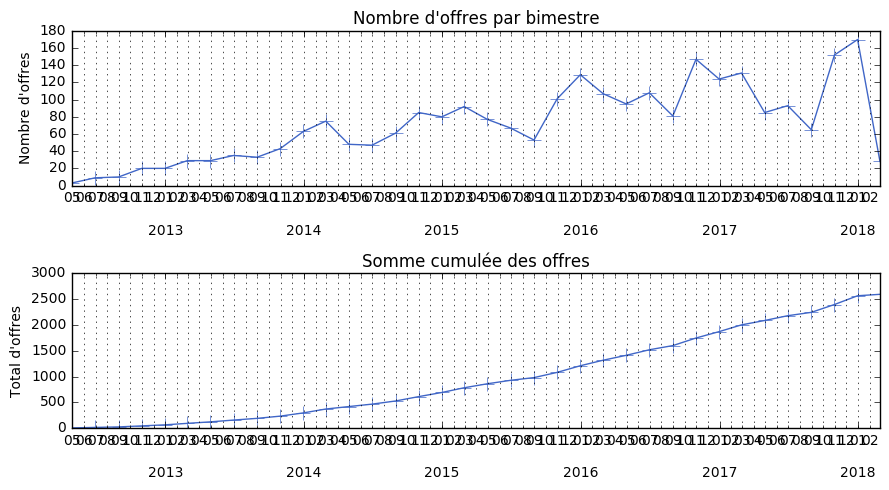

In [6]:
dd, mm = date_serie.index.to_pydatetime(), date_serie
cummm = date_serie.cumsum()

kwargsplot = {'marker': '+', 'markersize': 10, 'color': colors[3], 'lw': 1, 'ls': '-'}
fig, axx = plt.subplots(2,1, figsize=(9,5))
axx[0].plot_date(dd, mm, **kwargsplot) # on affiche la somme par mois
axx[1].plot_date(dd, cummm, **kwargsplot) # on affiche la somme cumulée

axx[0].set_title(u'Nombre d\'offres par bimestre')
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title(u'Somme cumulée des offres')
axx[1].set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.xaxis.set_minor_locator(mpldates.MonthLocator(bymonth=(1),interval=1))
    ax.xaxis.set_minor_formatter(mpldates.DateFormatter('%m'))
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.set_major_locator(mpldates.YearLocator())
    ax.xaxis.set_minor_locator(mpldates.MonthLocator())
    ax.xaxis.set_major_formatter(mpldates.DateFormatter('\n\n%Y'))
fig.tight_layout()

On voit que la fréquence de publication des offres augmente au cours du temps. On devine aussi quelques variations saisonnières, avec notamment un creux chaque année autour de la période estivale. Mais depuis plusieurs mois, la liste s'est maintenue au dessus de 1 offre par jour. À l'heure actuelle, le mois le plus riche en offres est le mois de novembre 2015 avec une moyenne de plus de 2,5 offres par jour. Il fait partie du bimestre le plus haut sur le graphe du haut.

Notons que la SFBI (et la liste de diffusion bioinfo) pousse de plus en plus à passer par son site internet, ce qui pourrait facilement expliquer cette croissance (notre jeu de données ne prend en compte que les offres hébergées par le site). Une question demeure, cependant : dans quelle mesure la progression observée ici reflète-elle la progression réelle de l'offre en bioinformatique ? En effet, tous les recruteurs ne passent pas nécessairement par la SFBI pour diffuser leurs offres. Il est donc toujours nécessaire de garder un peu de recul face à ces données.

## Évolution des types d'offres sur la période 2012-2016

De quels types d'offres parle-t-on ?
Est-ce que comme l'a évoqué [Sophie Schbath](http://bioinfo-fr.net/questions-a-sophie-schbath), la proportion de contrats courts augmente, ou s'agit-il d'un biais de perception ?
Un premier point intéressant serait de tracer le graphe précédent par type de contrat, ce qui se fait là encore très facilement dans Pandas.

In [7]:
df_per_type = df[['submission_date', 'contract_type']] # On crée un sous dataframe
df_per_type = df_per_type.set_index('submission_date') # On met les dates en index
gb = df_per_type.groupby(pd.TimeGrouper('2M')) # On groupe par période de 2 mois
# Enfin, on compte chaque occurence de contrat dans les périodes définies
df_count_per_type = gb.contract_type.apply(lambda x: x.value_counts()).unstack().fillna(0) 
df_count_per_type.head() # On affiche un petit aperçu

,CDD,CDI,Stage,Thèse
submission_date,,,,
2012-04-30,1.0,0.0,1.0,1.0
2012-06-30,6.0,0.0,0.0,3.0
2012-08-31,9.0,1.0,0.0,0.0
2012-10-31,15.0,3.0,2.0,0.0
2012-12-31,11.0,2.0,7.0,0.0


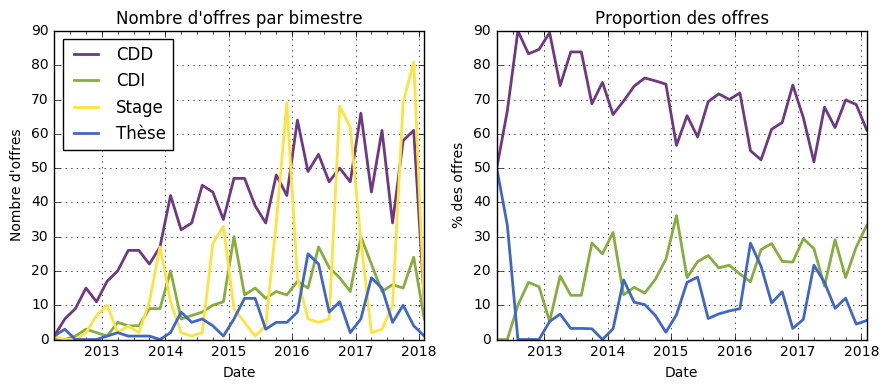

In [8]:
fig, axx = plt.subplots(1,2, figsize=(9,4))
df_count_per_type.plot(ax=axx[0], kind='line', color=colors, lw=2)
# On calcule les proportions sur les CDD, CDI et Thèses uniquement
df_proportion = df_count_per_type.drop('Stage',1).apply(lambda c: c/c.sum()* 100, axis=1)
# Les couleurs sont ajustées pour correspondre à l'ommision de la courbe 'Stage'
colors_nostage = [colors[0], colors[1], colors[3]]
df_proportion.plot(ax=axx[1], kind='line', color=colors_nostage, lw=2, legend=False)
# On définit proprement les titres et étiquettes de chaque graphe
axx[0].set_title("Nombre d'offres par bimestre")
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title("Proportion des offres")
axx[1].set_ylabel("% des offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()
fig.savefig('../../output/evo_contrats.svg')

On constate tout d'abord que les CDD sont majoritaires sur toute la période. Néanmoins, une nuance intéressante apparait dans le graphe supérieur droit : la proportion de CDD tend à diminuer. On passe en effet d'environ 65% de CDD dans tout le corpus d'offre en 2013, à 55% environ vers le milieu de 2016. Cette diminution tendancielle montre que l'augmentation du nombre de CDD proposés (visible dans le graphe inférieur gauche) n'arrive pas à suivre l'augmentation du nombre total des offres. D'autres catégories prennent donc un peu plus d'importance en proportion.

Coté variations saisonnières, les CDI montrent un pic pendant les mois de février 2014 et 2015 pour une raison qui nous échappe, mais ce phénomène ne semble pas s'être produit en 2016 (avec à la place, un pic de CDD ?). Certains membres de l'équipe l'expliquent par le climat d'incertitude actuel (on ne signe pas de nouveaux CDI à quelques semaines d'une modification majeure du code du travail, d'autant que rien n'est décidé). Pour d'autres, cela peut simplement venir de la baisse du nombre de postes dans le public, ou d'une catégorie d'offres qui n'apparaîtrait plus sur la liste. Cela mériterait une analyse plus fine. Quels types de CDI ont disparu ? Quels types de CDD sont apparus ? Un cookie à qui trouvera la meilleure explication (données à l'appui).

Concernant les stages et les thèses, on observe des variations très saisonnières : les stages montrent très peu d'offres toute l'année, et un énorme pic d'octobre à décembre (point culminant en novembre). Les thèses ont un petit pic au début de chaque année, probablement dû au fait que les concours d'écoles doctorales se tiennent de mai à juillet. Au final, pour maximiser ses chances il vaut mieux chercher son stage en novembre, et sa thèse en début d'année.

## Évolution des types de CDD sur la période 2012-2016

On rappelle que l'on a 4 sous-catégories de CDD dans la base, telles que définies sur le site de la SFBI au moment d'entrer une offre : Post-doc / IR, CDD Ingénieur, ATER, et CDD autre.
Le jeu de données ne comprend que 2 offres ATER sur toute la période, on va donc exclure cette catégorie de l'analyse.
Pour rappel, les Post-docs occupaient à eux seuls 50\% du nombre de CDD publiés dans notre dernier article.
Cette proportion a-t-elle changée au cours du temps ?

In [9]:
# On filtre pour ne garder que les CDDs, sans les ATER
df_CDD = df[(df['contract_type'] == 'CDD') & (df['contract_subtype'] != 'ATER')]
# On crée une sous dataframe
df_per_CDD_subtype = df_CDD[['submission_date', 'contract_subtype']]
# On met les dates en index
df_per_CDD_subtype = df_per_CDD_subtype.set_index('submission_date')
# On groupe par période de 2 mois
gb = df_per_CDD_subtype.groupby(pd.TimeGrouper('2M'))
# On compte chaque occurence de contrat
df_count_per_subtype = gb.contract_subtype.apply(lambda x: x.value_counts()).unstack().fillna(0)
df_count_per_subtype.head()

,CDD Ingénieur,CDD autre,Post-doc / IR
submission_date,,,
2012-04-30,0.0,0.0,1.0
2012-06-30,2.0,0.0,4.0
2012-08-31,3.0,0.0,6.0
2012-10-31,10.0,2.0,3.0
2012-12-31,2.0,3.0,6.0


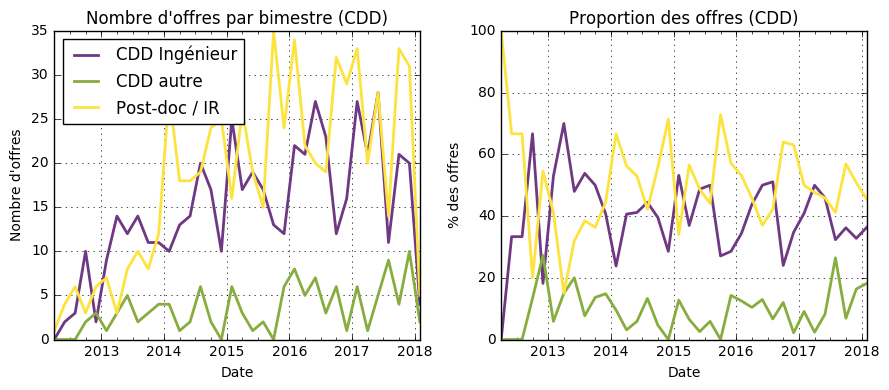

In [10]:
fig, axx = plt.subplots(1,2, figsize=(9,4))
df_count_per_subtype.plot(ax=axx[0], kind='line', color=colors, lw=2)
df_proportion = df_count_per_subtype.apply(lambda c: c/c.sum()* 100, axis=1)
df_proportion.plot(ax=axx[1], kind='line', color=colors, lw=2, legend=False)
axx[0].set_title("Nombre d'offres par bimestre (CDD)")
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title("Proportion des offres (CDD)")
axx[1].set_ylabel("% des offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()
fig.savefig('../../output/evo_CDD.svg')

Il semblerait que le parent pauvre des sous-types de CDD soit le CDD autre. On a ainsi massivement des CDD ingénieur ou Post-doc/IR, dans des proportions et augmentations comparables (bien que les Post-doc/IR progressent légèrement plus vite). Une séparation entre privé et public serait intéressante, mais nous n'avons pas les données nécessaires pour le faire à l'heure actuelle.

## Évolution de la durée des CDD sur la période 2012-2016

Une donnée à laquelle nous avons cependant accès est la durée de ces CDD. Les contrats signés ont-ils tendance à l'être pour des durées plus courtes ou plus longues ? Comme nous l'avons vu dans l'article précédent, la nature discrète des durées de contrats (seulement 33 valeurs uniques sur plus de 1400 offres, d'après le tableau en début d'article) rend les distributions de durées très asymétriques. Il peut donc être intéressant de visualiser ça sous forme de catégories.

In [11]:
# On définit nos catégories
list_categories = [u'≤ 1 an',
                   u'1 < x ≤ 2 ans', u'> 2 ans']
# On crée une fonction qui retourne la catégorie à partir de la durée en mois
def get_category(months):
    cat_num = months//12
    div_remain = months%12
    if div_remain == 0: cat_num -= 1# pour avoir ≤ et non pas <
    if cat_num < 2:
        return list_categories[cat_num]
    else:
        return list_categories[-1]

is_CDD = df.contract_type == 'CDD'
is_sanitized = (0 < df.duration) & (df.duration < 100)
df_duration = df[is_CDD & is_sanitized][['duration', 'submission_date']]
df_duration['category'] = df_duration.loc[:,'duration'].apply(get_category)
df_duration = df_duration.set_index('submission_date')
# On groupe par période de 2 mois
gb = df_duration.groupby(pd.TimeGrouper('2M'))
# On compte chaque occurence de contrat
df_count_per_duration = gb.category.apply(lambda x: x.value_counts()).unstack().fillna(0)
df_count_per_duration = df_count_per_duration.reindex(columns=list_categories)
df_count_per_duration.head()


,≤ 1 an,1 < x ≤ 2 ans,> 2 ans
submission_date,,,
2012-04-30,0.0,1.0,0.0
2012-06-30,2.0,3.0,0.0
2012-08-31,2.0,5.0,2.0
2012-10-31,7.0,6.0,0.0
2012-12-31,3.0,4.0,3.0


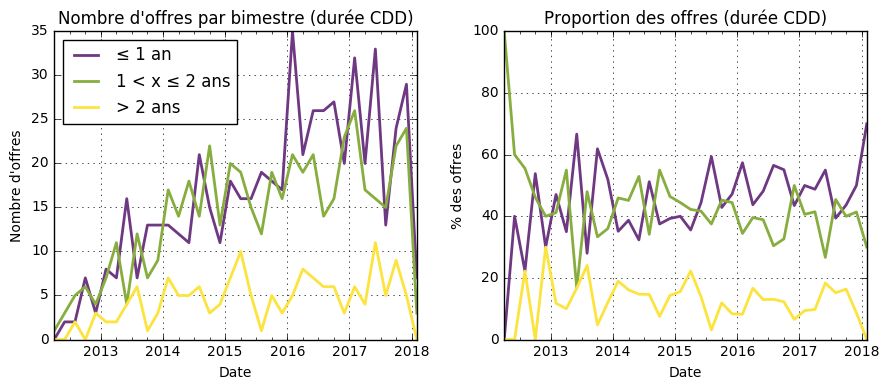

In [12]:
fig, axx = plt.subplots(1,2, figsize=(9,4))
df_count_per_duration.plot(ax=axx[0], kind='line', color=colors, lw=2)
df_proportion = df_count_per_duration.apply(lambda c: c/c.sum()* 100, axis=1)
df_proportion.plot(ax=axx[1], kind='line', color=colors, lw=2, legend=False)
axx[0].set_title("Nombre d'offres par bimestre (durée CDD)")
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title("Proportion des offres (durée CDD)")
axx[1].set_ylabel("% des offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()
fig.savefig('../../output/evo_duree.svg')

Finalement sur l'ensemble des CDD, les contrats courts (≤ 1 an) et les contrats moyens (entre 1 et 2 ans) augmentent à la même vitesse. Les contrats longs (plus de 2 ans) se maintiennent à une proportion constante sur la période. On a également essayé de tracer ça par type de contrat, mais nous n'avons pas vu de différences claires. On laisse à nos lecteurs curieux le soin d'explorer cette voie par eux même.

Au final, il n'y a pas d'argument majeur soutenant la thèse d'une diminution de la durée des contrats. On constate cependant un pic de contrats courts début 2016. Reste à voir si la tendance va se confirmer sur le reste de l'année. En tout cas, le pic de CDI habituellement observé en janvier-février semble avoir été remplacé cette année par un pic de contrats courts (mais ce n'est qu'une corrélation).

En conclusion, on a vu que l'on pouvait très facilement explorer ce jeu de données avec des commandes pandas bien construites.
Il y a probablement plein d'aspects auxquels nous n'avons pas pensé, et on compte sur vous pour nous aider à les explorer.
Les meilleurs graphes qui auront été proposés sur le Github du projet seront en effet au coeur de l'article suivant.